### Lecture 3

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.is_available()

False

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')


device

device(type='cpu')

In [4]:
noise_dim = 100

#### Generator Model

In [5]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.fcn = torch.nn.Sequential(
            # Fully Connected Layer 1
            torch.nn.Linear(
                in_features=noise_dim,
                out_features=240,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # Fully Connected Layer 2
            torch.nn.Linear(
                in_features=240,
                out_features=240,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # Fully Connected Layer 3
            torch.nn.Linear(
                in_features=240,
                out_features=240,
                bias=True
            ),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            # Fully Connected Layer 4
            torch.nn.Linear(
                in_features=240,
                out_features=784,
                bias=True
            ),
            torch.nn.Sigmoid()
        )

    def forward(self, batch):
        ret = batch.view(batch.size(0), -1)
        ret = self.fcn(ret)
        return ret

#### Maxout Activation

##### Source: https://github.com/pytorch/pytorch/issues/805

In [6]:
class Maxout(torch.nn.Module):

    def __init__(self, num_pieces):

        super(Maxout, self).__init__()

        self.num_pieces = num_pieces

    def forward(self, x):

        # x.shape = (batch_size? x 625)

        assert x.shape[1] % self.num_pieces == 0  # 625 % 5 = 0

        ret = x.view(
            *x.shape[:1],  # batch_size
            x.shape[1] // self.num_pieces,  # piece-wise linear
            self.num_pieces,  # num_pieces
            *x.shape[2:]  # remaining dimensions if any
        )
        
        # ret.shape = (batch_size? x 125 x 5)

        # https://pytorch.org/docs/stable/torch.html#torch.max        
        ret, _ = ret.max(dim=2)

        # ret.shape = (batch_size? x 125)

        return ret

#### Discriminator Model

In [7]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.fcn = torch.nn.Sequential(
            # Fully Connected Layer 1
            torch.nn.Linear(
                in_features=784,
                out_features=240,
                bias=True
            ),
            Maxout(5),
            # Fully Connected Layer 2
            torch.nn.Linear(
                in_features=48,
                out_features=240,
                bias=True
            ),
            Maxout(5),
            # Fully Connected Layer 3
            torch.nn.Linear(
                in_features=48,
                out_features=1,
                bias=True
            ),
            torch.nn.Sigmoid()
        )

    def forward(self, batch):
        ret = batch.view(batch.size(0), -1)
        ret = self.fcn(ret)
        return ret

### Lecture 4

#### MNIST Dataset

In [8]:
import torchvision

In [9]:
class FlattenTransform:
    
    def __call__(self, inputs):
        return inputs.view(inputs.shape[0], -1)
        

data_train = torchvision.datasets.MNIST(
    './data/mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        FlattenTransform()
    ])
)

In [10]:
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

#### GAN Training

In [11]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)


discriminator_optimizer = torch.optim.SGD(
    discriminator.parameters(),
    lr=0.005,
    momentum=0.7
)

generator_optimizer = torch.optim.SGD(
    generator.parameters(),
    lr=0.005,
    momentum=0.7
)

criterion = torch.nn.BCELoss()

In [12]:
real_labels = torch.ones(BATCH_SIZE, 1).to(device)
fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

test_set = torch.randn(16, noise_dim).to(device)

num_epochs = 512
num_steps = len(train_loader) // BATCH_SIZE

In [13]:
import os

if not os.path.exists('visuals-v2'):
    os.mkdir('visuals-v2')

In [14]:
for epoch in range(num_epochs):

    for i, (images, _) in enumerate(train_loader):

        if i == num_steps:
            break

        # Train Discriminator
        for _ in range(16):
        
            real_images = images.to(device)

            fake_images = generator(
                torch.randn(BATCH_SIZE, noise_dim).to(device)
            )

            discriminator_optimizer.zero_grad()

            real_outputs = discriminator(real_images)
            fake_outputs = discriminator(fake_images)

            d_x = criterion(real_outputs, real_labels)
            d_g_z = criterion(fake_outputs, fake_labels)

            d_x.backward()
            d_g_z.backward()

            discriminator_optimizer.step()

        # Train Generator
        z = torch.randn(BATCH_SIZE, noise_dim).to(device)

        generator.zero_grad()

        outputs = discriminator(generator(z))

        loss = criterion(outputs, real_labels)

        loss.backward()

        generator_optimizer.step()

    # Visualize Results
    if epoch % 10 == 0:

        generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)

        grid = torchvision.utils.save_image(
            generated,
            os.path.join(
                'visuals-v2',
                '{}.jpg'.format(
                    str(epoch).zfill(6)
                )
            ),
            nrow=4,
            padding=10,
            pad_value=1
        )

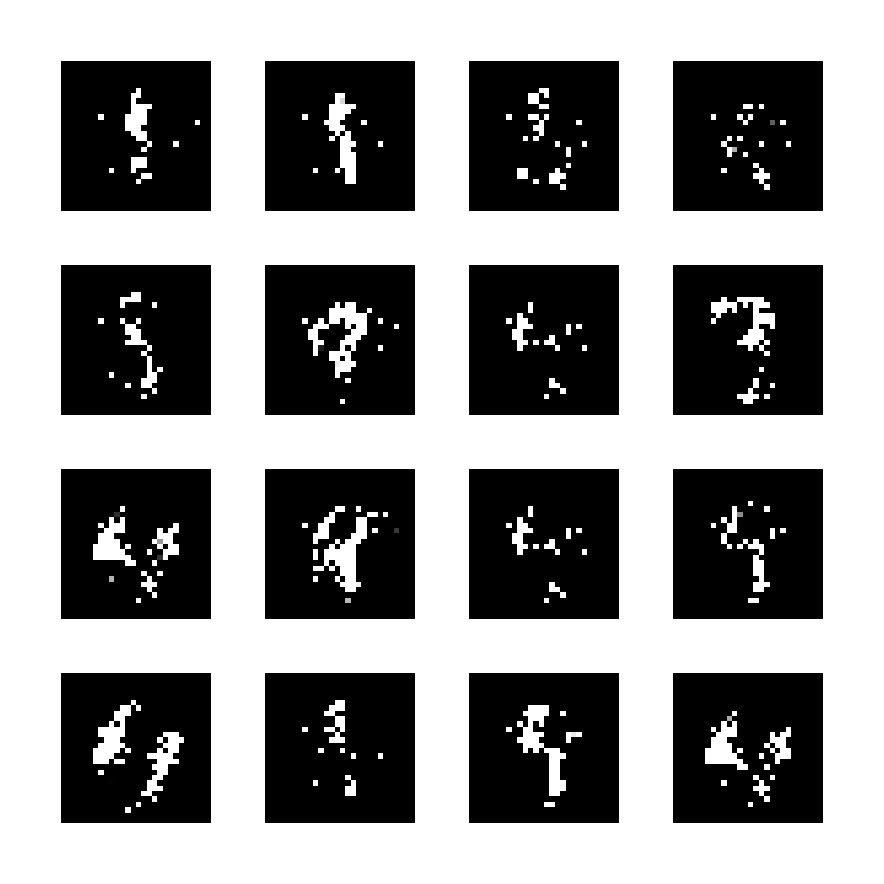

In [15]:
# Visualize Results
generated = generator(test_set).detach().cpu().view(-1, 1, 28, 28)

grid = torchvision.utils.make_grid(
    generated,
    nrow=4,
    padding=10,
    pad_value=1
)

img = np.transpose(
    grid.numpy(),
    (1, 2, 0)
)

fig = plt.figure(figsize=(16, 16))
plt.axis("off")
plt.imshow(img);

#### Google Collaboratory

Notebook: https://colab.research.google.com/drive/1ZFvYoDhrLrUwrv-hUpNXJGxndEeRvl8H

#### Evaluation Metrics: Inception Score


Source: https://sudomake.ai/inception-score-explained/

In [16]:
import math
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import inception_v3

# initialize pretrained inception network
net = inception_v3(pretrained=True).to(device)


def inception_score(images, batch_size):

  # list of scores
  scores = []

  # number of steps
  num_steps = int(math.ceil(float(len(images)) / float(batch_size)))

  # iterate over the images
  for i in range(num_steps):

    # mini-batch start and end index
    s = i * batch_size
    e = (i + 1) * batch_size

    # mini-batch images
    mini_batch = images[s:e]

    # mini-batch as Torch tensor with gradients
    batch = Variable(mini_batch)

    # apply a forward pass through inception network
    # skipping aux logits
    '''
     This network is unique because it has two output layers when training.
     The second output is known as an auxiliary output and is contained in the AuxLogits part of the network.
     The primary output is a linear layer at the end of the network.
     Note, when testing we only consider the primary output.
    '''
    s, _ = net(batch)

    # accumulate scores
    scores.append(s)

  # stack scores as tensor
  scores = torch.cat(scores, 0)

  # calculate inception score

  '''
  The formula for inception score
  IS(x) = E[ KL( P(y|x) || P(y)) ]
  x: generated images
  y: inception model classification distribution aka softmax
  '''

  # calculate p(y|x) across dimension 1
  # that is one row for each image
  p_yx = F.softmax(scores, 1)

  # calculate p(y) across dimension 0
  # that is one column for each class / label
  p_y = p_yx.mean(0).unsqueeze(0).expand(p_yx.size(0), -1)

  # calculate KL divergence
  KL_d = p_yx * (torch.log(p_yx) - torch.log(p_y))

  # calculate mean aka expected of KL
  final_score = KL_d.mean()

  # return final score
  return final_score

In [17]:
# test inception score on generated images

# generate images
images = generator(test_set)

# reshape to 1x28x28
images = images.view(-1, 1, 28, 28)

# repeat Gray channel to RGB
images = images.repeat(1, 3, 1, 1)

# resize the images to 3x299x299
res_images = F.interpolate(images, size=(299, 299))

# calculate inception score
score = inception_score(res_images, BATCH_SIZE)

# get value from tensor variable
score.item()

0.0004470464482437819

In [1]:
# test inception score on real images

# load mini batch from dataset
images, _ = next(iter(train_loader))

# convert to GPU
images = images.to(device)

# reshape to 1x28x28
images = images.view(-1, 1, 28, 28)

# repeat Gray channel to RGB
images = images.repeat(1, 3, 1, 1)

# resize the images to 3x299x299
res_images = F.interpolate(images, size=(299, 299))

# calculate inception score
score = inception_score(res_images, BATCH_SIZE)

# get value from tensor variable
score.item()

NameError: name 'train_loader' is not defined